train loss:2.299954881515226
=== epoch:1, train acc:0.119, test acc:0.099 ===
train loss:2.29804267740831
train loss:2.2936837021373897
train loss:2.2912573629656126
train loss:2.281889127572752
train loss:2.268992077001456
train loss:2.2546298810797194
train loss:2.234259565764542
train loss:2.218795197279899
train loss:2.1837250536694914
train loss:2.1624600300288765
train loss:2.1312908365544305
train loss:2.086288003543357
train loss:2.0893970927250787
train loss:2.0061073649609473
train loss:1.943133911033385
train loss:1.8676208349067052
train loss:1.8431811752644414
train loss:1.7496048922782412
train loss:1.661025981668129
train loss:1.6096392132682544
train loss:1.4673839581285986
train loss:1.4259400363912542
train loss:1.3535521858341466
train loss:1.3360580934829216
train loss:1.2202656354878194
train loss:1.1248169348767632
train loss:1.0836317235243795
train loss:1.0671509500276086
train loss:0.8570401701952045
train loss:0.775195337974346
train loss:0.7992579975522163
tr

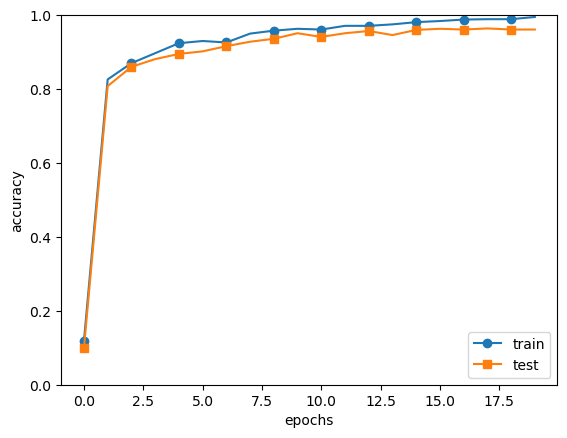

In [1]:
import sys
import os
sys.path.append(os.pardir)  
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from layers import *
from gradient import numerical_gradient
from dataset.mnist import load_mnist
from trainer import Trainer


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):

        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()